# DoubleML binary outcome/treatment variables



Ref:
https://arxiv.org/pdf/1806.04823.pdf

https://github.com/py-why/EconML/issues/204

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use("seaborn-whitegrid")


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/2907140941.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## Create dummy data

In [2]:
def logit(p):
    return np.log(p) - np.log(1 - p)


def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))


def no_confound(x: np.array):
    return np.zeros(x.shape[0])


def linear_confound(x: np.array, a: float = 1.0, b: float = 0.5):
    return a * x[:, 0] + b


def generate_data(
    n_samples: int = 1000,
    n_features: int = 4,
    treatment_binary: bool = False,
    outcome_binary: bool = False,
    seed: int = None,
    confounding_fcn: callable = None,
    treatment_noise: float = 0.1,
    outcome_noise: float = 0.1,
):
    if confounding_fcn is None:
        confounding_fcn = no_confound

    rand = np.random.default_rng(seed)

    # generate random features
    x = rand.normal(
        loc=rand.normal(size=n_features),
        scale=rand.exponential(size=n_features),
        size=(n_samples, n_features),
    )

    t_x = confounding_fcn(x)
    if treatment_binary:
        t = rand.binomial(n=1, p=inv_logit(t_x), size=n_samples)
    else:
        t = treatment_noise * rand.normal(size=n_samples) + t_x

    bias = rand.normal()
    weights = rand.normal(size=(n_features + 1, 1))
    y = (
        bias
        + np.dot(np.concatenate([t[:, np.newaxis], x], axis=1), weights)
        + outcome_noise * rand.normal()
    )

    if outcome_binary:
        y = rand.binomial(n=1, p=inv_logit(y), size=(n_samples, 1))

    x_cols = [f"x_{idx+1}" for idx in range(n_features)]
    t_col = "t"
    y_col = "y"
    df = pd.DataFrame(x, columns=x_cols)
    df[t_col] = t
    df[y_col] = y
    df = df[[y_col, t_col] + x_cols]

    return df, bias, weights, x_cols


## Linear case

In [3]:
import sklearn.linear_model


In [4]:
df, bias, weights, x_cols = generate_data(
    treatment_binary=False,
    outcome_binary=False,
    confounding_fcn=None,
    outcome_noise=1.0,
    treatment_noise=1.0,
)

print("True weights")
print(bias)
print(weights.flatten())

linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X=df[["t"] + x_cols], y=df["y"])
print("Est weights")
print(linear_model.intercept_)
print(linear_model.coef_)


True weights
0.616520517201611
[-1.4271995  -1.10630387  1.41771083  1.12794191 -0.73898064]
Est weights
0.12321277683908649
[-1.4271995  -1.10630387  1.41771083  1.12794191 -0.73898064]


### With confounders

Linear regression gives biased outcomes when ignoring x_1 the confounder

In [5]:
def linear_confound(x: np.array, a: float = 1.0, b: float = 0.5):
    return a * x[:, 0] + b


df, bias, weights, x_cols = generate_data(
    treatment_binary=False,
    outcome_binary=False,
    confounding_fcn=linear_confound,
    outcome_noise=1.0,
    treatment_noise=0.1,
)

print("True weights")
print(bias)
print(weights.flatten())


linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X=df[x_cols], y=df["y"])
print("Est weights (ignore confounder)")
print(linear_model.intercept_)
print(linear_model.coef_)

linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X=df[["t"] + x_cols], y=df["y"])
print("Est weights")
print(linear_model.intercept_)
print(linear_model.coef_)


True weights
-0.6086835973443033
[ 0.82431597  0.11390388  0.66203475 -0.14398739 -0.60797301]
Est weights (ignore confounder)
-0.33761034215697294
[ 0.93726718  0.6645215  -0.15172712 -0.60710827]
Est weights
-0.752312092396708
[ 0.82431597  0.11390388  0.66203475 -0.14398739 -0.60797301]


Residualise treatment with features

In [6]:
treatment_model = sklearn.linear_model.LinearRegression()
treatment_model.fit(X=df[x_cols], y=df["t"])
print("Est weights")
print(treatment_model.intercept_)
print(treatment_model.coef_)

df = df.drop(columns=["t_resid"], errors="ignore")
df = df.assign(t_resid=df["t"] - treatment_model.predict(df[x_cols]))


Est weights
0.5030859110758522
[ 0.99884429  0.00301674 -0.00938927  0.00104904]


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/2777063384.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/2777063384.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


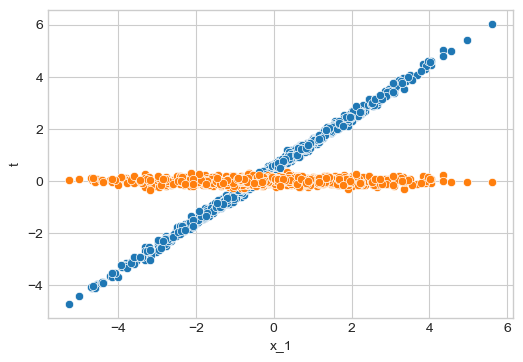

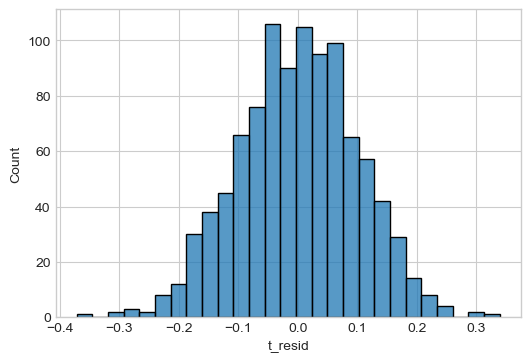

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="t", x="x_1", ax=ax)
sns.scatterplot(data=df, y="t_resid", x="x_1", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="t_resid", ax=ax)
fig.show()


Residualise outcome

In [8]:
outcome_model = sklearn.linear_model.LinearRegression()
outcome_model.fit(X=df[x_cols], y=df["y"])
print("Est weights")
print(outcome_model.intercept_)
print(outcome_model.coef_)

df = df.drop(columns=["y_resid"], errors="ignore")
df = df.assign(y_resid=df["y"] - outcome_model.predict(df[x_cols]))


Est weights
-0.3376103421569753
[ 0.93726718  0.6645215  -0.15172712 -0.60710827]


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/1686059054.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/1686059054.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


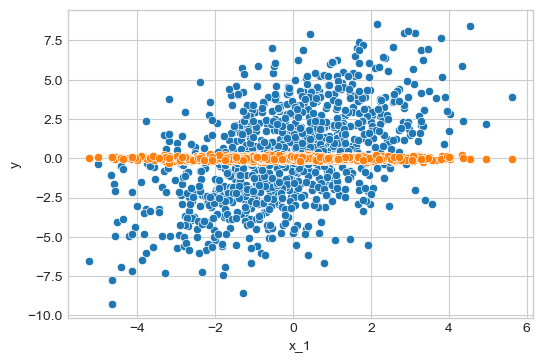

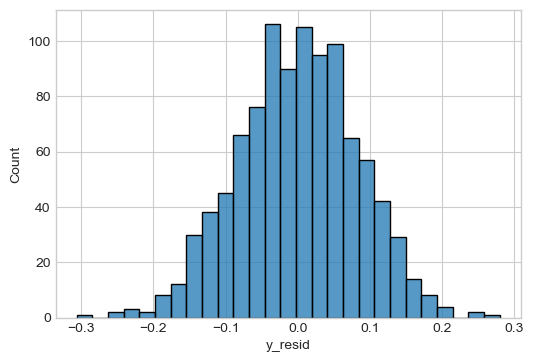

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="y", x="x_1", ax=ax)
sns.scatterplot(data=df, y="y_resid", x="x_1", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="y_resid", ax=ax)
fig.show()


Model on residuals

In [10]:
residuals_model = sklearn.linear_model.LinearRegression()
residuals_model.fit(X=df[["t_resid"]], y=df["y_resid"])

print("True weights")
print(bias)
print(weights.flatten())

print("Est weights")
print(residuals_model.intercept_)
print(residuals_model.coef_)

df = df.drop(columns=["yt_resid"], errors="ignore")
df = df.assign(yt_resid=df["y_resid"] - residuals_model.predict(df[["t_resid"]]))


True weights
-0.6086835973443033
[ 0.82431597  0.11390388  0.66203475 -0.14398739 -0.60797301]
Est weights
1.6340025297892289e-16
[0.82431597]


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/563212422.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/563212422.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


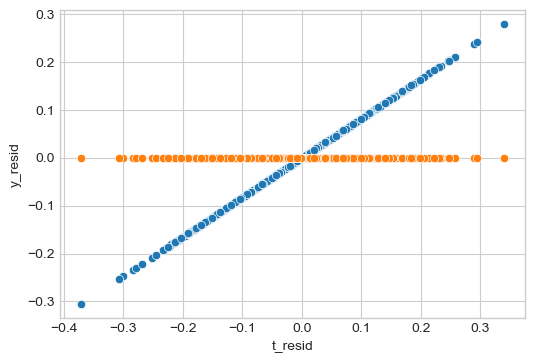

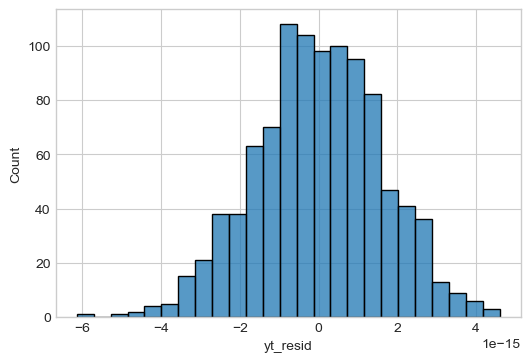

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="y_resid", x="t_resid", ax=ax)
sns.scatterplot(data=df, y="yt_resid", x="t_resid", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="yt_resid", ax=ax)
fig.show()


## Binary outcome case

In [12]:
def linear_confound(x: np.array, a: float = 1.0, b: float = 0.5):
    return a * x[:, 0] + b


df, bias, weights, x_cols = generate_data(
    treatment_binary=False,
    outcome_binary=True,
    confounding_fcn=linear_confound,
    outcome_noise=1.0,
    treatment_noise=0.1,
)

print("True weights")
print(bias)
print(weights.flatten())


linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X=df[x_cols], y=df["y"])
print("Est weights (ignore confounder)")
print(linear_model.intercept_)
print(linear_model.coef_)

linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X=df[["t"] + x_cols], y=df["y"])
print("Est weights")
print(linear_model.intercept_)
print(linear_model.coef_)


True weights
0.22325577120705145
[ 0.18376595 -0.96558229  1.52843524 -0.57829744 -1.21811306]
Est weights (ignore confounder)
0.48385476916401887
[-0.04086771  0.07572716 -0.09360409 -0.0526939 ]
Est weights
0.3797854699015448
[ 0.21016316 -0.25066519  0.07566906 -0.09597374 -0.05153659]


Residualise treatment with features

In [13]:
treatment_model = sklearn.linear_model.LinearRegression()
treatment_model.fit(X=df[x_cols], y=df["t"])
print("Est weights")
print(treatment_model.intercept_)
print(treatment_model.coef_)

df = df.drop(columns=["t_resid"], errors="ignore")
df = df.assign(t_resid=df["t"] - treatment_model.predict(df[x_cols]))


Est weights
0.4951833605131952
[ 9.98260036e-01  2.76451713e-04  1.12752649e-02 -5.50675246e-03]


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/2777063384.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/2777063384.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


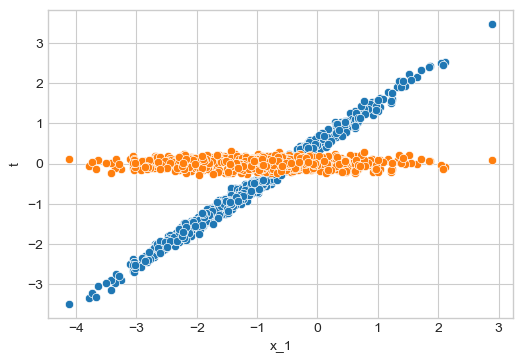

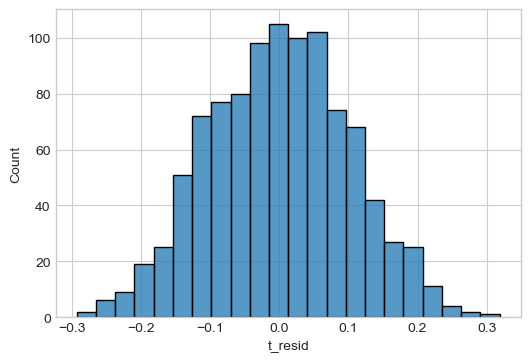

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="t", x="x_1", ax=ax)
sns.scatterplot(data=df, y="t_resid", x="x_1", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="t_resid", ax=ax)
fig.show()


Residualise outcome with linear regression


Does this make any sense?

In [15]:
outcome_model = sklearn.linear_model.LinearRegression()
outcome_model.fit(X=df[x_cols], y=df["y"])
print("Est weights")
print(outcome_model.intercept_)
print(outcome_model.coef_)

df = df.drop(columns=["y_resid_lin"], errors="ignore")
df = df.assign(y_resid_lin=df["y"] - outcome_model.predict(df[x_cols]))


Est weights
0.4838547691640188
[-0.04086771  0.07572716 -0.09360409 -0.0526939 ]


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/3369394391.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/3369394391.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


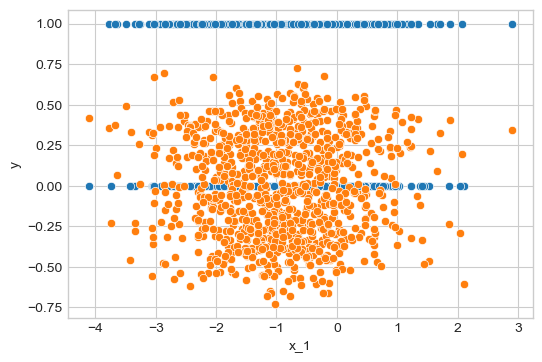

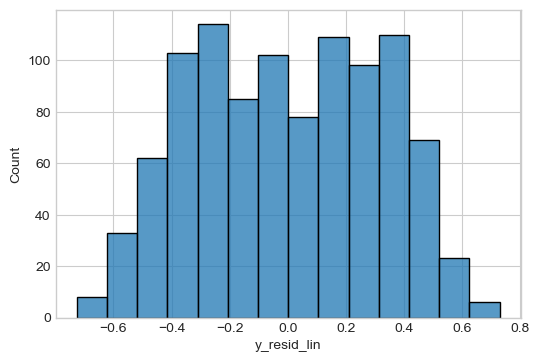

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="y", x="x_1", ax=ax)
sns.scatterplot(data=df, y="y_resid_lin", x="x_1", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="y_resid_lin", ax=ax)
fig.show()


Model on residuals

In [17]:
residuals_model = sklearn.linear_model.LinearRegression()
residuals_model.fit(X=df[["t_resid"]], y=df["y_resid_lin"])

print("True weights")
print(bias)
print(weights.flatten())

print("Est weights")
print(residuals_model.intercept_)
print(residuals_model.coef_)

df = df.drop(columns=["yt_resid_lin"], errors="ignore")
df = df.assign(yt_resid_lin=df["y_resid_lin"] - residuals_model.predict(df[["t_resid"]]))


True weights
0.22325577120705145
[ 0.18376595 -0.96558229  1.52843524 -0.57829744 -1.21811306]
Est weights
-2.6847336010160037e-17
[0.21016316]


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/2804571276.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/2804571276.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


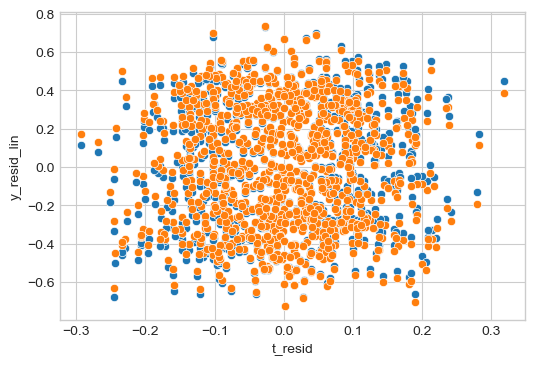

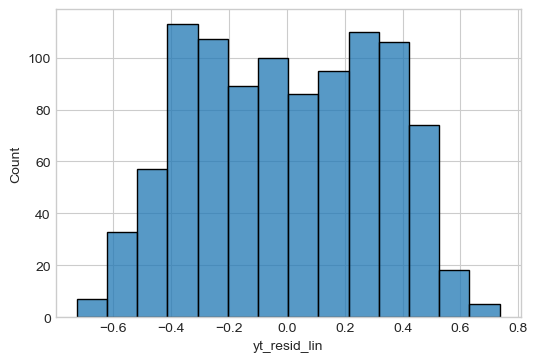

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="y_resid_lin", x="t_resid", ax=ax)
sns.scatterplot(data=df, y="yt_resid_lin", x="t_resid", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="yt_resid_lin", ax=ax)
fig.show()


Using logistic regression instead

In [19]:
outcome_model = sklearn.linear_model.LogisticRegression()
outcome_model.fit(X=df[x_cols], y=df["y"])
print("Est weights")
print(outcome_model.intercept_)
print(outcome_model.coef_)

df = df.drop(columns=["y_resid_log"], errors="ignore")
df = df.assign(y_resid_log=df["y"] - outcome_model.predict_proba(df[x_cols])[:,1])


Est weights
[-0.37248567]
[[-0.73584468  1.3873093  -1.78475881 -1.0434716 ]]


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/1117081880.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/1117081880.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


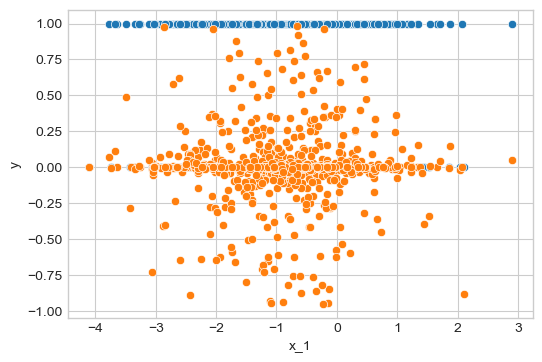

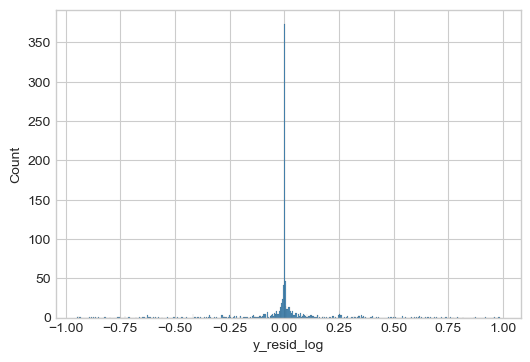

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="y", x="x_1", ax=ax)
sns.scatterplot(data=df, y="y_resid_log", x="x_1", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="y_resid_log", ax=ax)
fig.show()


Model on residuals

In [21]:
residuals_model = sklearn.linear_model.LinearRegression()
residuals_model.fit(X=df[["t_resid"]], y=df["y_resid_log"])

print("True weights")
print(bias)
print(weights.flatten())

print("Est weights")
print(residuals_model.intercept_)
print(residuals_model.coef_)

df = df.drop(columns=["yt_resid_log"], errors="ignore")
df = df.assign(yt_resid_log=df["y_resid_log"] - residuals_model.predict(df[["t_resid"]]))


True weights
0.22325577120705145
[ 0.18376595 -0.96558229  1.52843524 -0.57829744 -1.21811306]
Est weights
3.4159154787806355e-07
[0.14278501]


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/2557261485.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/2557261485.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


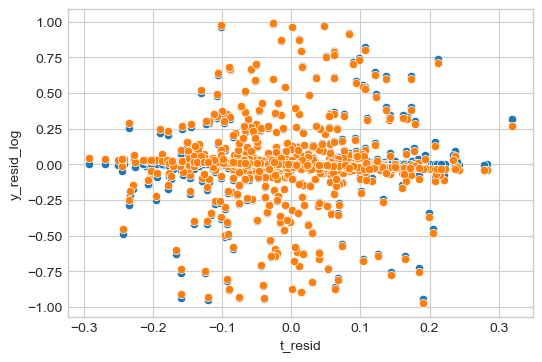

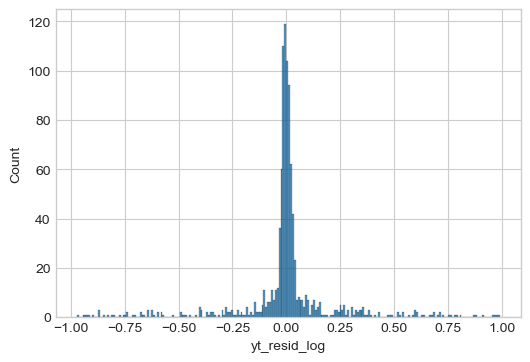

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="y_resid_log", x="t_resid", ax=ax)
sns.scatterplot(data=df, y="yt_resid_log", x="t_resid", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="yt_resid_log", ax=ax)
fig.show()


The coefficient estimate is poor.

Are we estimating coefficients here or effect size? With a logistic model they are not the same.

Comparison to single logistic regression

Which gives a reasonable estimate.

In [23]:
print("True weights")
print(bias)
print(weights.flatten())

logistic_model = sklearn.linear_model.LogisticRegression()
logistic_model.fit(X=df[['t']+x_cols], y=df["y"])
print("Est weights")
print(logistic_model.intercept_)
print(logistic_model.coef_)

True weights
0.22325577120705145
[ 0.18376595 -0.96558229  1.52843524 -0.57829744 -1.21811306]
Est weights
[-0.51028969]
[[ 0.28961842 -1.01988211  1.38483256 -1.78921876 -1.04207265]]


Comparison to single linear regression

This gives the same results as the DoubleML model using linear regression for each step.
The coefficients have a different meaning the logits from the logistic regression model, so we don't expect them to be the same.

In [24]:
print("True weights")
print(bias)
print(weights.flatten())

linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X=df[['t']+x_cols], y=df["y"])
print("Est weights")
print(linear_model.intercept_)
print(linear_model.coef_)

True weights
0.22325577120705145
[ 0.18376595 -0.96558229  1.52843524 -0.57829744 -1.21811306]
Est weights
0.3797854699015448
[ 0.21016316 -0.25066519  0.07566906 -0.09597374 -0.05153659]


# TODO

In the linear model case:

$$
Y = \theta(X) \cdot T + X\beta + \epsilon
$$
$$
T = a \cdot X_1 + b + \eta
$$


With a binary outcome:

$$
Y = \mathrm{bin} ( \theta(X) \cdot T + X\beta + \epsilon)
$$
$$
T = a \cdot X_1 + b + \eta
$$



Plot treatment with features